In [20]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [21]:
class Classifier(d2l.Module): #@save
    """The base class of classification models."""
    def validation_step(self,batch):
        Y_hat=self(*batch[:-1])
        self.plot('loss',self.loss(Y_hat,batch[-1]),train=False)
        self.plot('acc',self.accuracy(Y_hat,batch[-1]),train=False)
        

In [22]:
@d2l.add_to_class(Classifier) #@save
def accuracy(self,Y_hat,Y,averaged=True):
    """Compute the number of correct predictions."""
    Y_hat=Y_hat.reshape((-1,Y_hat.shape[-1]))
    preds=Y_hat.argmax(axis=1).type(Y.dtype)
    compare=(preds==Y.reshape(-1)).type(torch.float32)
    return compare.mean() if averaged else compare

In [23]:
class CustomOptimizerRegressionScratch(d2l.Classifier): #@save
    """The regression model with my optimizer implemented from scratch."""
    def __init__(self,num_inputs,num_outputs,lr,sigma=0.01):
    # def __init__(self,num_inputs,num_outputs,lr,M,sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w=torch.normal(0,sigma,size=(num_inputs,num_outputs), requires_grad=True)
        self.b=torch.zeros(num_outputs,requires_grad=True)

    def parameters(self):
        return [self.w,self.b]

In [24]:
def softmax(X):
    X_exp=torch.exp(X)
    partition=X_exp.sum(1,keepdims=True)
    return X_exp/partition # The broadcasting mechanism is applied here

In [25]:
@d2l.add_to_class(CustomOptimizerRegressionScratch) #@save
def forward(self,X):
    X=X.reshape((-1,self.w.shape[0]))
    return softmax(torch.matmul(X,self.w)+self.b)

In [26]:
class MyOptimizer(d2l.HyperParameters): #@save
    """결과값으로의 중력값을 사용하는 momentum을 사용합니다"""
    def __init__(self,params,lr):
        self.save_hyperparameters()
        for param in params:
            param.m = torch.zeros_like(param)
            #cosine needed
            # param.cosine = torch.zeros_like(param)
        
        

    def step(self):
        #Momentum
        for param in self.params:
           param.m=0.03*param.m-self.lr*param.grad
           param+=param.m

        # gravity momentum
        # for param in self.params:
        #     # tmp=param.grad/math.sqrt(param.grad.size()[0])
        #     tmp=param.grad/param.grad.size()[0]
        #     S=(torch.square(tmp)).sum()
        #     val=1+(self.lr**2)/S if S>0 else 1
        #     k=math.sqrt(val) if val>0 else 1
             
        #     param.m=0.03*param.m-k*self.lr*param.grad
        #     param+=param.m
            
        # cosine momentum
        # for param in self.params:
        #    for m,g,cos in zip(param.m, param.grad, param.cosine):
        #        product = torch.dot(m,g) if m.dim()!=0 and g.dim()!=0 else 0
        #        m_norm = torch.norm(m)
        #        g_norm = torch.norm(g)
        #        cosine_value = product / (m_norm * g_norm) if m_norm!=0 and g_norm!=0 else 0
        #        cos.fill_(cosine_value)
            
        #    param.m=0.0225*((param.cosine+1)/2)*param.m+self.lr*param.grad
        #    param-=param.m
        
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()


In [27]:
@d2l.add_to_class(CustomOptimizerRegressionScratch) #@save
def configure_optimizers(self):
    return MyOptimizer([self.w,self.b],self.lr)
    # return SGD([self.w,self.b],self.lr)

In [28]:
def cross_entropy(y_hat,y):
    return -torch.log(y_hat[range(len(y_hat)),y]).mean()

@d2l.add_to_class(CustomOptimizerRegressionScratch) #@save
def loss(self,y_hat,y):
  return cross_entropy(y_hat,y)

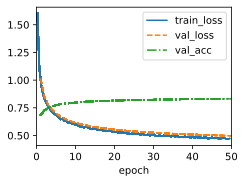

In [29]:
data = d2l.FashionMNIST(batch_size=256)
model=CustomOptimizerRegressionScratch(num_inputs=784,num_outputs=10,lr=0.01)
trainer=d2l.Trainer(max_epochs=50)
trainer.fit(model,data)

In [30]:
X,y=next(iter(data.val_dataloader()))
preds=model(X).argmax(axis=1)
preds.shape

torch.Size([256])

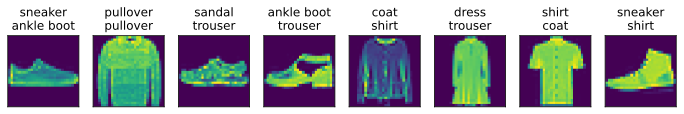

In [31]:
wrong=preds.type(y.dtype)!=y
X,y,pres=X[wrong],y[wrong],preds[wrong]
labels=[a+'\n'+b for a,b in zip(
  data.text_labels(y),data.text_labels(preds))]
data.visualize((X,y),labels=labels)